<h1><img align="right" width="350" src="img/ATU-Logo-Full-RGB-Green.jpg"> Programming for Data Analysis - Project 1
</h1>
<p> 
Course: HDip in Computing in Data Analytics <br>
Module: Programming for Data Analysis <br>
Lecturer: Brian McGinley <br>
Project: Project 1 for the Programming for Data Analysis module of the HDip in Data Analytics beginning January 2023. 
    
Student: Eilis Donohue (G00006088)

Project spec:
See ProgDAProject.pdf

Software Used: 
 - Python v3.10 and higher
 - Jupyter Notebook 6.5.2   
 </p>

## Table of Contents
- [Introduction](#Intro)
- [Dataset Ingest and Preparation](#Prep)
- [Preliminary Analysis](#Prelim)
- [Overall Variable Correlation](#Corr)
- [Rainfall Analysis](#Rain)
- [Pressure Analysis](#Pressure)
- [Temperature Analysis](#Temperature)
- [Wind Speed Analysis](#Wind)
- [Data Synthesisation](#Synth)
- [Conclusions](#Conclusions)
- [References](#Refs)

## Introduction <a id="Intro"></a> <span style="font-size: 8pt;"> [[TOC]](#toc)</span>

The historical meteorological data from the weather station at Athenry, Co. Galway has been downloaded for 10 years from the met.ie website [1]. This dataset comprises a number of meteological variables as previewed below. The raw dataset (hly1875.csv) is stored in the \data folder. For the purposes of this study, the following variables have been chosen for analysis and data synthesisation.

- Rainfall
- Air Temperature
- Mean sealevel pressure
- Mean Wind speed

Each row of the raw dataset is an hourly recording of each variable.  This study is summarised as follows:

1. A preliminary analysis of the dataset (4 variables above) is performed to gain some insight into the overall trends and data distribution.
2. To simplify the data and its synthesisation, a daily aggregation of the variables is performed based on mean (and daily summation in the case of rainfall).
3. As weather is seasonal, a season variable is assigned to the data to allow for potentially more accurate distribution fitting and data synthesisation.
4. Each of the four variables above is analysed and a distribution is fitted based on curve fitting to the real data histograms. **Scipy stats** is used to generate fitted distributions and choose the most appropriate distribution for each dataset.
5. Data is synthesised using appropriate **Numpy** random number generators models using the distribution features found in step 4. 
6. The synthesised data is outputted to a csv file (synthesised_met_data.csv) in /data.

## Date Ingest and Preparation  <a id="Prep"></a> <span style="font-size: 8pt;"> [[TOC]](#toc)</span>

This section has the code used to ingest the data csv file and do some preparation of the data (i.e., convert the numeric fields to floats and remove blankspaces). The following steps are taken to prepare the data:

1. The data is read in to a **Pandas** dataframe.
2. The 4 variables of interest are isolated and copied to another dataframe.
3. The timestamp in the dataset is converted to a datetime object. The data is indexed by datetime as appropriate.  
4. Weather is inherently seasonal, so a new variable season is added to the dataframe based on the month (i.e., meteorological winter is December to February inclusive, and so on).
5. The data is reduced to a daily aggregation based on the daily mean or sum (in the case of rainfall).

In [1]:
# Import the required packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm, rayleigh, lognorm, multivariate_normal, expon, weibull_min
from scipy.optimize import *
import numpy as np
import math

In [2]:
# Some function definitions
# Returns a season designation based on month to a dataframe 
def split_seasons(df_to_split, months):
  season_df = pd.DataFrame()
  for month in months:
    month_loc = df_to_split['datetime'].dt.month.between(month, month)
    season_df = pd.concat([season_df, df_to_split.loc[month_loc]])
  return season_df

# Returns Pearsons correlation on dataframe
def get_corr(data):
    return data.corr()

# assigns a season class to the data to allow for referencing of data without splitting dataframe
def assign_season_class(the_data, the_class, months):
  for month in months:
    month_loc = the_data['datetime'].dt.month.between(month, month)
    the_data.loc[month_loc, 'season'] = the_class
  return the_data

# function to find the midpoints of a array of bins (returned from plt.hist())
def mean_bins(given_bins):
  bins = []
  for i in range(len(given_bins[:-1])):
    bins.append((given_bins[i]+given_bins[i+1])/2)
  return np.array(bins)

# Define a styler for tables 
def my_styler(df, precision, caption):
    df_styler = df.style.format(precision=precision).set_caption(caption)
    return df_styler 

# Highlights values in a table between left and right values. Returns a styler object that can be displayed
def styler_highlight_between(df_styler, left, right):
    print(f"{left} {right}")
    df_styler = df_styler.highlight_between(color="#fffd75", left=left, right=right, inclusive='both') 
    return df_styler
  

In [3]:
# Import the full met.ie dataset (downloaded from https://www.met.ie/climate/available-data/historical-data)
all_data_df = pd.read_csv("data/Athenry_met/hly1875.csv", skiprows=17)

In [4]:
# Return all the columns of the raw dataset
all_data_df.columns.values

array(['date', 'ind', 'rain', 'ind.1', 'temp', 'ind.2', 'wetb', 'dewpt',
       'vappr', 'rhum', 'msl', 'ind.3', 'wdsp', 'ind.4', 'wddir'],
      dtype=object)

In [5]:
# Set index to be datetime
all_data_df['datetime'] = pd.to_datetime(all_data_df['date'])
all_data_df = all_data_df.set_index(all_data_df['datetime'])
all_data_df.drop(columns=['date'], inplace=True)

In [6]:
# Taking the data since 2012 to end 2022
time_start = "2012-01-01 00:00:00"
time_end = "2022-12-31 23:00:00"
# data_df is the time period to analyse
data_df = all_data_df.loc[time_start : time_end].copy()
data_df

,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl,ind.3,wdsp,ind.4,wddir,datetime
datetime,,,,,,,,,,,,,,,
2012-01-01 00:00:00,0,0.1,0,9.0,0,7.7,6.1,9.4,82,998.4,2,14,2,230,2012-01-01 00:00:00
2012-01-01 01:00:00,0,0.0,0,9.1,0,7.7,6.0,9.3,80,998.1,2,15,2,220,2012-01-01 01:00:00
2012-01-01 02:00:00,0,1.4,0,7.4,0,6.5,5.4,9.0,87,998.0,2,17,2,240,2012-01-01 02:00:00
2012-01-01 03:00:00,0,0.2,0,8.3,0,6.6,4.4,8.4,76,997.9,2,15,2,230,2012-01-01 03:00:00
2012-01-01 04:00:00,0,0.0,0,8.2,0,6.1,3.3,7.7,71,997.7,2,14,2,230,2012-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,0,0.0,0,4.4,0,4.2,4.0,8.1,96,992.9,2,3,2,40,2022-12-31 19:00:00
2022-12-31 20:00:00,0,0.0,0,4.5,0,4.3,4.1,8.2,97,993.4,2,1,2,50,2022-12-31 20:00:00
2022-12-31 21:00:00,0,0.0,0,4.6,0,4.4,4.2,8.2,96,994.0,2,3,2,30,2022-12-31 21:00:00


In [7]:
# Replace blankspace with nan [2]
data_df = data_df.replace(r'^\s+$', np.nan, regex=True)

In [8]:
# Take 4 met variables - hourly rainfall, temperature, sealevel pressure and relative humidity
# Convert the 4 chosen variables to float types
data_df[['rain', 'temp', 'msl', 'wdsp']] = data_df[['rain', 'temp', 'msl', 'wdsp']].astype(float)
# Create a smaller dataframe with the required variables
mydata_df = data_df[['rain', 'temp', 'msl', 'wdsp', 'datetime']].copy()

In [9]:
# Aggregate the data based on daily mean or sum (in the case of rainfall)
mydata_agg = pd.DataFrame()
mydata_agg['Rainfall sum'] = data_df[['rain', 'datetime']].groupby(pd.Grouper(key='datetime', freq='D')).sum()
mydata_agg['Temp mean'] = data_df[['temp', 'datetime']].groupby(pd.Grouper(key='datetime', freq='D')).mean()
mydata_agg['Pressure mean'] = data_df[['msl', 'datetime']].groupby(pd.Grouper(key='datetime', freq='D')).mean()
mydata_agg['Windspeed mean'] = data_df[['wdsp', 'datetime']].groupby(pd.Grouper(key='datetime', freq='D')).mean()

In [10]:
# Call a function to split the data and return the data based on a season
# Put datetime back as a variable [3]

mydata_agg_i = mydata_agg.reset_index()
winter_months = [12, 1, 2]
spring_months = [3, 4, 5]
summer_months = [6, 7, 8]
autumn_months = [9, 10, 11]

# assign a new variable "season" to the data
mydata_agg_i['season'] = ''
mydata_agg_i = assign_season_class(mydata_agg_i, 'winter', winter_months)
mydata_agg_i = assign_season_class(mydata_agg_i, 'spring', spring_months)
mydata_agg_i = assign_season_class(mydata_agg_i, 'summer', summer_months)
mydata_agg_i = assign_season_class(mydata_agg_i, 'autumn', autumn_months)
print(mydata_agg_i.head(10))

class_names = ['winter', 'spring', 'summer', 'autumn']  # to allow looping over seasons
var_names = ['Rainfall sum', 'Temp mean', 'Pressure mean', 'Windspeed mean'] # to allow looping over variables
plot_titles = ['Rainfall', 'Temperature', 'Pressure', 'Wind Speed']
units_names = ['(mm)', '(deg C)', '(hPa)', '(knots)']

    datetime  Rainfall sum  Temp mean  Pressure mean  Windspeed mean  season
0 2012-01-01           5.5   6.183333     996.729167       12.041667  winter
1 2012-01-02          11.0   4.387500     999.454167       10.541667  winter
2 2012-01-03           9.2   6.666667     996.112500       18.208333  winter
3 2012-01-04          10.9   7.733333    1012.091667       17.500000  winter
4 2012-01-05           2.4   8.308333    1013.979167       12.833333  winter
5 2012-01-06           2.7   8.516667    1023.958333       10.208333  winter
6 2012-01-07           0.0   8.145833    1025.754167        7.916667  winter
7 2012-01-08           0.8   9.683333    1026.583333       10.166667  winter
8 2012-01-09           1.5   8.787500    1027.887500        8.125000  winter
9 2012-01-10           5.8   9.816667    1028.495833       10.750000  winter


## Preliminary Analysis <a id="Prelim"></a> <span style="font-size: 8pt;"> [[TOC]](#toc)</span> 

The preliminary analysis of the dataset is carried out to assess the overall statistics and variations of the variables.
 
- Firstly, the histograms of the entire dataset are plotted - this is the distribution of the hourly data. The number of bins was chosen based on iterative process to achieve best balance to minimise noise in the data, and to identify the underlying trends in the data.
- The boxplots are used to visualise the main summary statistics of the dataset. The median of each variable is represented by the orange line with the box itself enclosing the middle 50% of the data or interquartile range (from the 25% to the 75% quartile). Seasonal variations can be identified easily. The skew and spread of the data can be qualitatively shown.

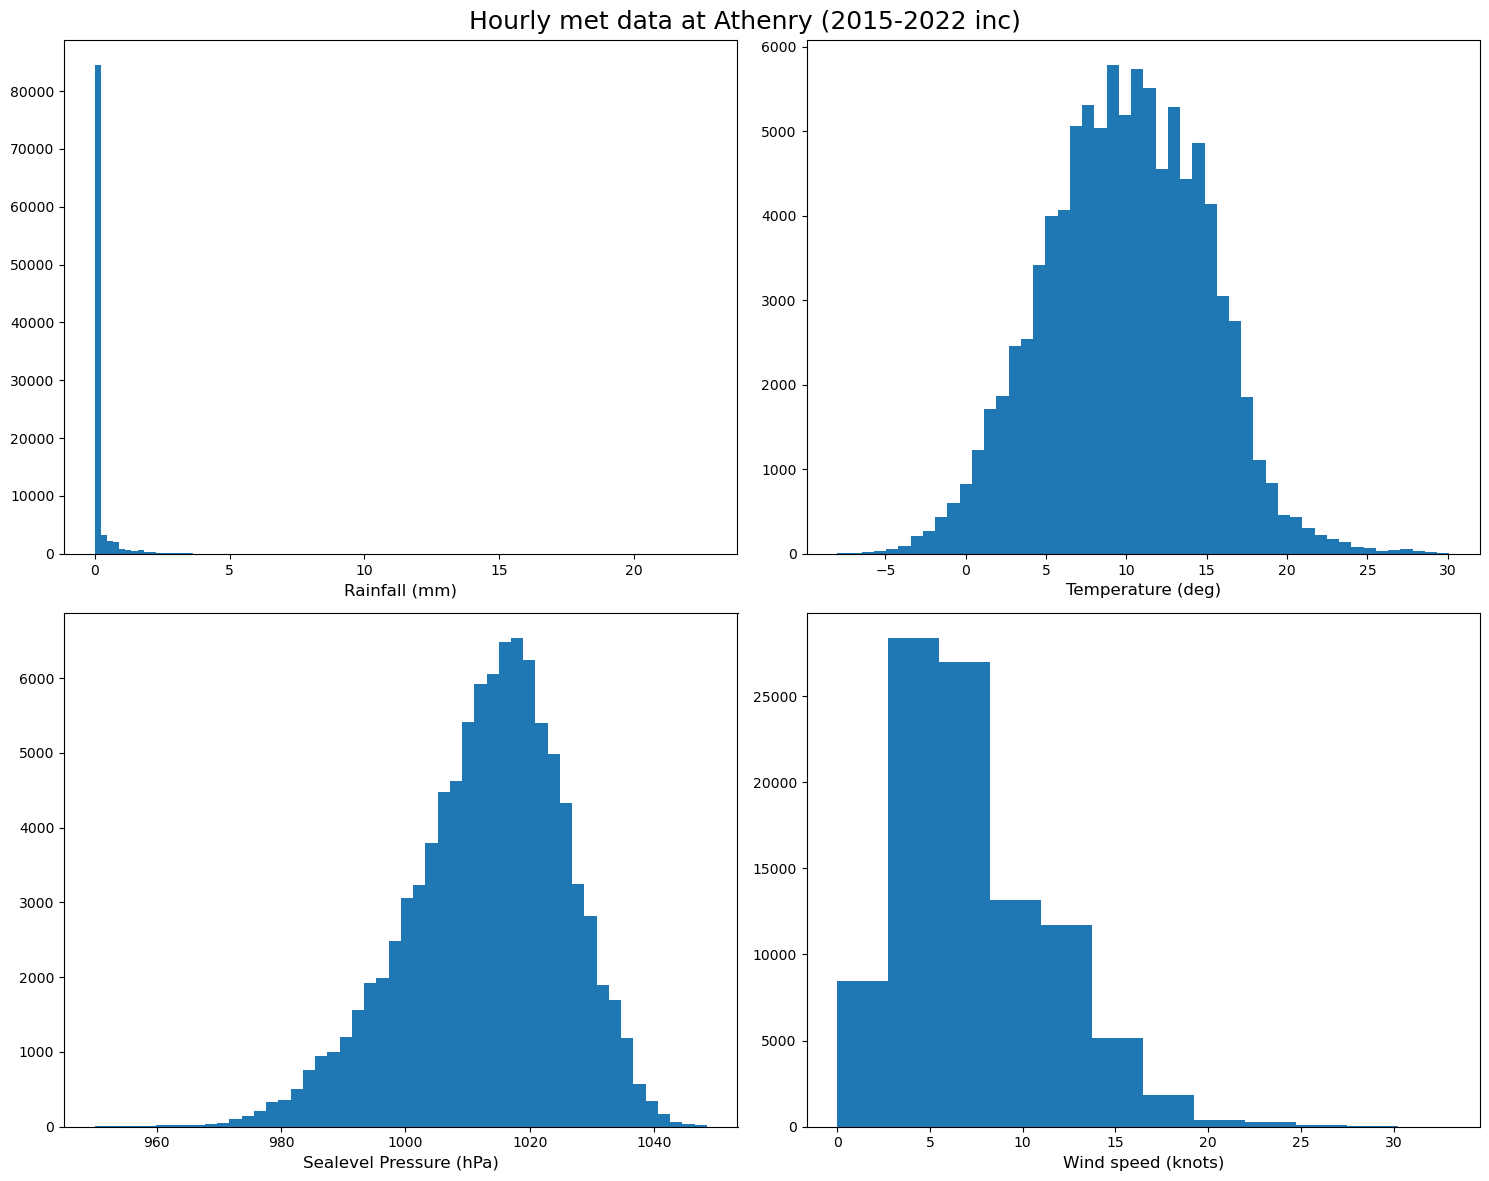

In [11]:
# Plots of the 8 year dataset for the 4 chosen variables
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle("Hourly met data at Athenry (2015-2022 inc)", fontsize=18)
axs[0,0].hist(data_df['rain'], bins=100)
axs[0,0].set_xlabel('Rainfall (mm)', fontsize=12)
axs[0,1].hist(data_df['temp'], bins=50)
axs[0,1].set_xlabel('Temperature (deg)', fontsize=12)
axs[1,0].hist(data_df['msl'], bins=50)
axs[1,0].set_xlabel('Sealevel Pressure (hPa)', fontsize=12)
axs[1,1].hist(data_df['wdsp'], bins=12)
axs[1,1].set_xlabel('Wind speed (knots)', fontsize=12)

plt.tight_layout()
plt.show()


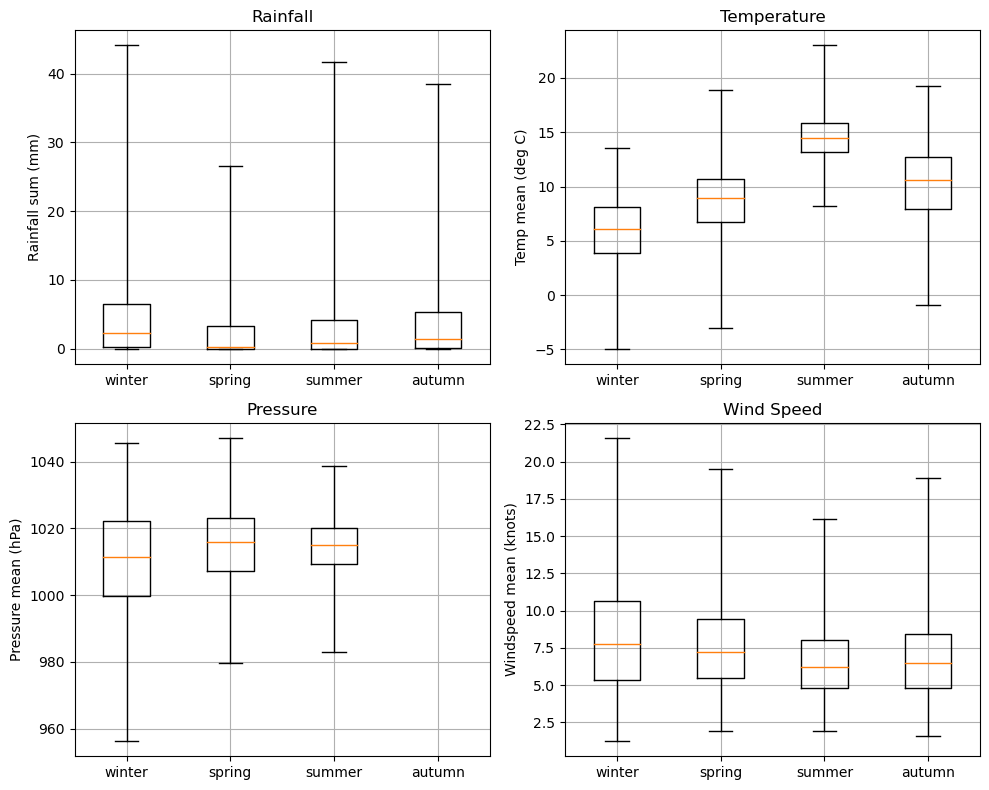

In [12]:
# Set up 1 fig with 4 boxplots
fig, axs = plt.subplots(2,2, figsize=(10, 8))
for i, var in enumerate(var_names):
    ax_list = [(0,0), (0,1), (1,0), (1,1)] 

    # create list of data to do a boxplot
    plot_data = [mydata_agg_i[var].loc[mydata_agg_i['season'] == 'winter'],
                mydata_agg_i[var].loc[mydata_agg_i['season'] == 'spring'],
                mydata_agg_i[var].loc[mydata_agg_i['season'] == 'summer'],
                mydata_agg_i[var].loc[mydata_agg_i['season'] == 'autumn']]

    # whis is arbitrarily high so that the whiskers represent min and max
    axs[ax_list[i]].boxplot(plot_data, whis=10000)   
    axs[ax_list[i]].set_ylabel(f'{var} {units_names[i]}')
    axs[ax_list[i]].set_xticklabels(class_names, fontsize=10)
    axs[ax_list[i]].set_title(plot_titles[i], fontsize=12)
    axs[ax_list[i]].grid(visible=True, which='both', axis='both')
fig.tight_layout() 


In [13]:
# troubleshooting pressure for autumn (for some reason, the boxplot will not display for pressure in autumn)

plot_data = [mydata_agg_i['Pressure mean'].loc[mydata_agg_i['season'] == 'winter'],
                mydata_agg_i['Pressure mean'].loc[mydata_agg_i['season'] == 'spring'],
                mydata_agg_i['Pressure mean'].loc[mydata_agg_i['season'] == 'summer'],
                mydata_agg_i['Pressure mean'].loc[mydata_agg_i['season'] == 'autumn']]

print(mydata_agg_i['Pressure mean'].loc[mydata_agg_i['season'] == 'autumn'].describe())

count     999.000000
mean     1012.093806
std        12.110551
min       974.829167
25%      1003.568750
50%      1013.300000
75%      1021.183333
max      1041.250000
Name: Pressure mean, dtype: float64


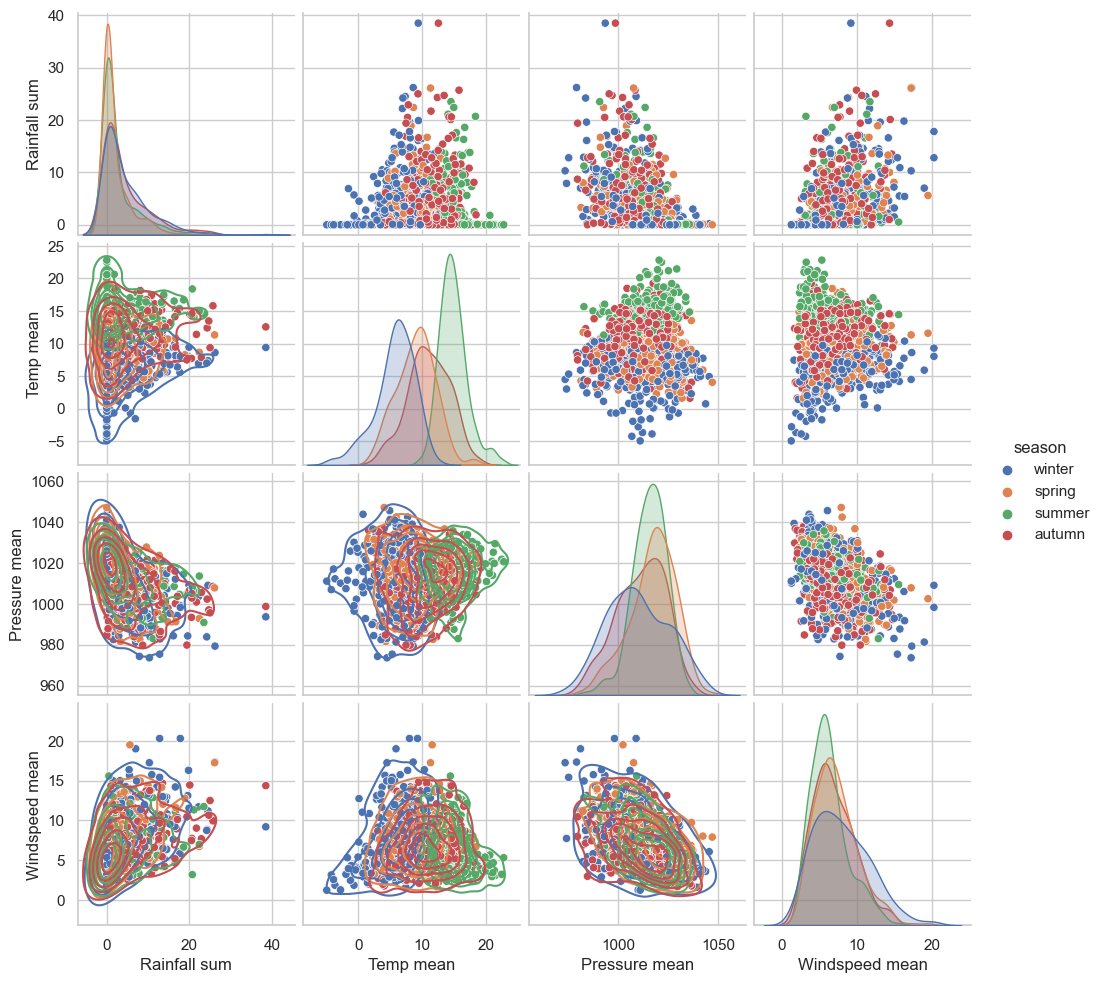

In [14]:
# Create a pairplot of the data for 3 years
sns.set_theme(style='whitegrid')
# take 3 years of data for the plot
data_3years = mydata_agg_i.loc[mydata_agg_i['datetime'].between('2020-01-01', '2022-12-31')]
g = sns.pairplot(data_3years, hue="season", diag_kind="kde")
g.map_lower(sns.kdeplot, levels=7, color=".2")
plt.show()

## Overall Variable Correlation <a id="Corr"></a> <span style="font-size: 8pt;"> [[TOC]](#toc)</span> 
In order to investigate correlation between the data variables, the Pearson correlation method in pandas is applied to the data (by season).

- Overall, there is no very strong correlation between any of the data variables investigated as part of this study. This was inferred above in the pairplot. Correlation values greater or less than 0.3 and -0.3 respectively are highlighted in the tables below.  

- The strongest correlations are between pressure and windspeed and pressure and rainfall. The correlation between pressure and windspeed ranges between -0.37 and -0.46 and ranges from from -0.49 to -0.42 between pressure and rainfall.   

- Winter shows the highest degree of correlation between the variables.

In [15]:
# Display the correlation table for the entire dataset
corr_styler_list = []
df_corr =  get_corr(mydata_agg_i.drop(columns = ["season", "datetime"]))    
df_styler = my_styler(df_corr, 2,  "Correlation - all data")
df_styler = styler_highlight_between(df_styler, 0.3, 0.99)
df_styler = styler_highlight_between(df_styler, -0.99, -0.3)
corr_styler_list = [df_styler]

# Get correlation matrices for the 4 seasons and display
for i, item in enumerate(class_names):
    # Extract the data related to one season
    season_data = mydata_agg_i[mydata_agg_i["season"] == item].copy()
    # Strip the class column before passing to function
    season_data.drop(columns = ["season", "datetime"], inplace=True) 
    df_corr =  get_corr(season_data)      
    df_styler = my_styler(df_corr, 2, item + " Correlation")
    df_styler = styler_highlight_between(df_styler, 0.3, 0.99)
    df_styler = styler_highlight_between(df_styler, -0.99, -0.3)
    corr_styler_list.append(df_styler)
    
for item in corr_styler_list:
    display(item)



0.3 0.99
-0.99 -0.3
0.3 0.99
-0.99 -0.3
0.3 0.99
-0.99 -0.3
0.3 0.99
-0.99 -0.3
0.3 0.99
-0.99 -0.3


,Rainfall sum,Temp mean,Pressure mean,Windspeed mean
Rainfall sum,1.00,0.01,-0.45,0.37
Temp mean,0.01,1.00,0.12,-0.04
Pressure mean,-0.45,0.12,1.00,-0.39
Windspeed mean,0.37,-0.04,-0.39,1.00


,Rainfall sum,Temp mean,Pressure mean,Windspeed mean
Rainfall sum,1.00,0.23,-0.45,0.47
Temp mean,0.23,1.00,0.01,0.45
Pressure mean,-0.45,0.01,1.00,-0.41
Windspeed mean,0.47,0.45,-0.41,1.00


,Rainfall sum,Temp mean,Pressure mean,Windspeed mean
Rainfall sum,1.00,-0.06,-0.48,0.38
Temp mean,-0.06,1.00,0.15,-0.07
Pressure mean,-0.48,0.15,1.00,-0.39
Windspeed mean,0.38,-0.07,-0.39,1.00


,Rainfall sum,Temp mean,Pressure mean,Windspeed mean
Rainfall sum,1.00,-0.04,-0.47,0.24
Temp mean,-0.04,1.00,0.18,-0.23
Pressure mean,-0.47,0.18,1.00,-0.44
Windspeed mean,0.24,-0.23,-0.44,1.00


,Rainfall sum,Temp mean,Pressure mean,Windspeed mean
Rainfall sum,1.00,0.13,-0.43,0.39
Temp mean,0.13,1.00,0.06,0.23
Pressure mean,-0.43,0.06,1.00,-0.35
Windspeed mean,0.39,0.23,-0.35,1.00


## Rainfall Analysis <a id="Rain"></a> <span style="font-size: 8pt;"> [[TOC]](#toc)</span> 
### Rainfall data analysis
- The rainfall is highly skewed towards values of zero. The data here may be seen as split into two regimes - the time or days when there is no rain and then those times or days when there is rain as is done here [4].
- It is useful to remove the 0 rainfall days by imposing a 1mm limit to determine a "rainy day" v "dry day". This approach is used here [4].
- Rainfall over a period of time can follow an exponential distribution [4] when the 0 rainfall periods are removed. The exponential distribution is shown below and appears to be a good fit to the "rainy day" data [6].  

The exponential distribution:

$$
f(x;\lambda) = 
\begin{cases} 
\lambda e^{-\lambda x} & \text{if } x \geq 0 \\
0 & \text{if } x < 0 
\end{cases}
$$

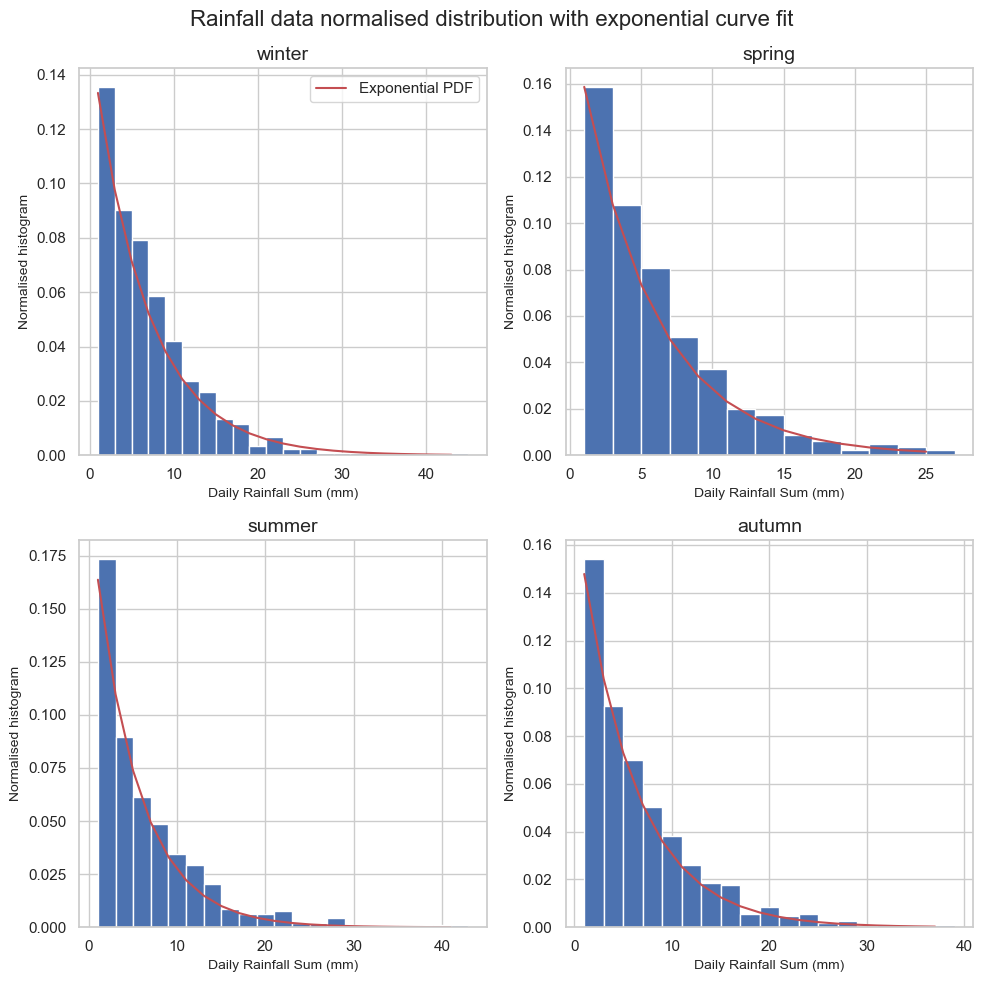

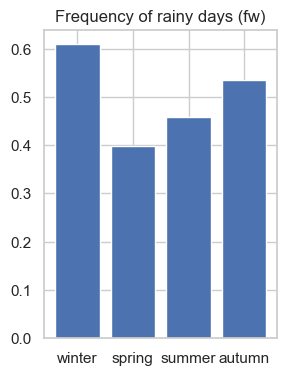

In [16]:
# Do some analysis on the daily aggregated rainfall data over 10 years.
rainfall_df = mydata_agg_i[['Rainfall sum', 'datetime', 'season']]
rainfall_df = rainfall_df.set_index('datetime')
max_rain = rainfall_df['Rainfall sum'].max()
min_rain = rainfall_df['Rainfall sum'].min()

fig, axs = plt.subplots(2,2, figsize=(10, 10));
fig.suptitle('Rainfall data normalised distribution with exponential curve fit', fontsize=16)

# Define empty lists to store the rainfall params and frequency from the curve fit for data synthesisation later
rainfall_exp_params_season = []
fw_seasonal = []
for i, season in enumerate(class_names):
  rainfall_df_season = pd.DataFrame()
  rainfall_df_season = rainfall_df[rainfall_df['season'] == season].drop(columns=['season'])
  # frequency of rainy days with criterion of >1mm rainfall in a day
  fw = (rainfall_df_season['Rainfall sum']>1).sum() / len(rainfall_df_season)
  fw_seasonal.append(fw)
  daily_rain_rainydays = rainfall_df_season[rainfall_df_season['Rainfall sum']>1]
  # defining the bin size
  bin_size = 2
  # find the min and max of the data
  daily_rain_rainydays_floor = math.floor(daily_rain_rainydays['Rainfall sum'].min())
  daily_rain_rainydays_ceiling = math.ceil(daily_rain_rainydays['Rainfall sum'].max())

  # generate a list of bins based on the above to fit the data
  bins = np.arange(daily_rain_rainydays_floor, daily_rain_rainydays_ceiling+bin_size, bin_size)
  ax_list = [(0,0), (0,1), (1,0), (1,1)] 
  # returns the normalised data for the histogram (area under curve =1)

  n, bins_returned, _ = axs[ax_list[i]].hist(daily_rain_rainydays['Rainfall sum'], bins=bins, density=True)
  bin_start = np.array(bins[:-1])

  # Use curve_fit method as in: https://stackoverflow.com/questions/50448199/lognormal-curve-fit
  # PDF for the exponential distribution - so that curve fitting can be done
  def f_exp(bin_start, lamda_1):
    return lamda_1*np.exp(-1*lamda_1*bin_start)

  # returns the exponential distribution parameters for the data fit
  params, extras = curve_fit(f_exp, bin_start, n)

  # fit a exponential curve
  lamda_1 = params[0]
  pdf_expon = (lamda_1*np.exp(-1*lamda_1*bin_start))
  rainfall_exp_params_season.append(lamda_1)

  axs[ax_list[i]].plot(bin_start, pdf_expon, 'r', label='Exponential PDF')
  axs[ax_list[i]].set_xlabel(f'Daily Rainfall Sum (mm)', fontsize=10)
  axs[ax_list[i]].set_ylabel(f'Normalised histogram', fontsize=10)
  axs[ax_list[i]].set_title(season, fontsize=14)
  axs[ax_list[i]].grid(visible=True, which='both', axis='both')
axs[(0,0)].legend();
fig.tight_layout()
fig, ax = plt.subplots(1, figsize=(3, 4));
ax.bar(class_names, fw_seasonal);
ax.set_title("Frequency of rainy days (fw)");


## Pressure Analysis <a id="Pressure"></a> <span style="font-size: 8pt;"> [[TOC]](#toc)</span> 
The seasonal mean sea level pressure is plotted below and a log normal distribution is fitted to the data.

- From the preliminary analysis above, the distribution of pressure is skewed to the left.
- Trying a lognormal normal distribution seems to provide a reasonably accurate fit to the data. There is some underestimation at lower values. 


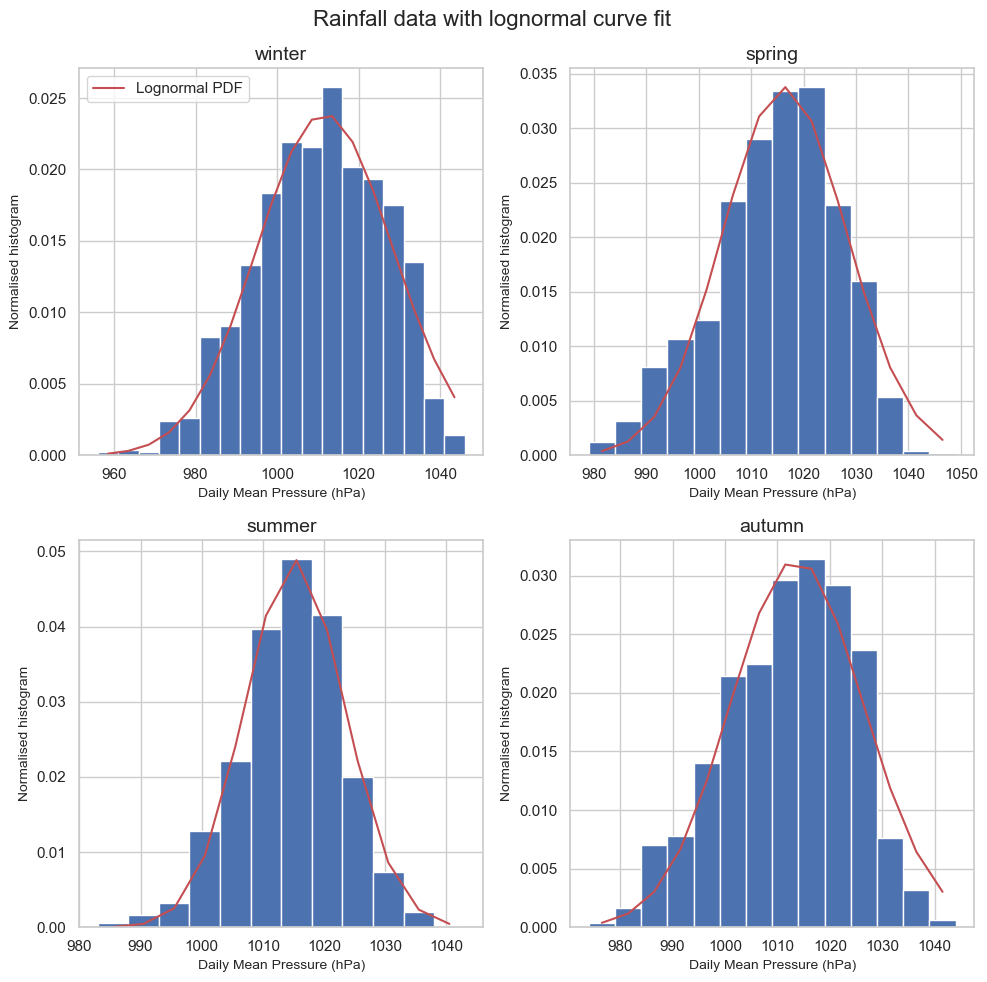

In [17]:
# Define empty lists to store the pressure params and frequency from the curve fit for data synthesisation later
pressure_params_season = []
pressure_df = mydata_agg_i[['Pressure mean', 'datetime', 'season']]
pressure_df = pressure_df.set_index('datetime')
# 
fig, axs = plt.subplots(2,2, figsize=(10, 10));
fig.suptitle('Rainfall data with lognormal curve fit', fontsize=16)
# Axis list for looping over axes below
ax_list = [(0,0), (0,1), (1,0), (1,1)] 
  
for i, season in enumerate(class_names):
  pressure_df_season = pd.DataFrame()
  pressure_df_season = pressure_df[pressure_df['season'] == season].drop(columns=['season'])
  
  # defining the bin size
  bin_size = 5
  # find the min and max of the data
  data_floor = math.floor(pressure_df_season['Pressure mean'].min())
  data_ceiling = math.ceil(pressure_df_season['Pressure mean'].max())

  # Generate a list of bins based on the min and max above to fit the data
  bins = np.arange(data_floor, data_ceiling+bin_size, bin_size)
  # Returns the normalised data for the histogram (area under curve =1)
  n, bins_returned, _ = axs[ax_list[i]].hist(pressure_df_season['Pressure mean'], bins=bins, density=True)
  
  # Gets the mid-point of the bins
  bin_mid = mean_bins(bins_returned)

# https://en.wikipedia.org/wiki/Log-normal_distribution
# This could be moved into functions section 
  def f_lognormal(x, mu, sigma):
    return 1/(np.sqrt(2*np.pi)*sigma*x)*np.exp(-((np.log(x)-mu)**2)/(2*sigma**2))

  # returns mu and sigma in params 
  params, extras = curve_fit(f_lognormal, bin_mid, n)
  mu_pressure = params[0]
  sigma_pressure = params[1]
  # store tuples to this list for use in the data synth later
  pressure_params_season.append((mu_pressure, sigma_pressure))
  # fit a lognormal curve
  pdf_lognormal = f_lognormal(bin_mid, mu_pressure, sigma_pressure)

  axs[ax_list[i]].plot(bin_mid, pdf_lognormal, 'r', label='Lognormal PDF')
  axs[ax_list[i]].set_xlabel(f'Daily Mean Pressure (hPa)', fontsize=10)
  axs[ax_list[i]].set_ylabel(f'Normalised histogram', fontsize=10)
  axs[ax_list[i]].set_title(season, fontsize=14)
  axs[ax_list[i]].grid(visible=True, which='both', axis='both')
axs[(0,0)].legend();
fig.tight_layout()

## Temperature Data Analysis <a id="Temperature"></a> <span style="font-size: 8pt;"> [[TOC]](#toc)</span> 
Qualitatively, the preliminary analysis of temperature distribution above shows a broadly normal distribution.  The normal distribution PDF is given below.
A Log normal PDF curve was also fitted. The normal and log normal fits are almost coincident for winter, spring and autumn which shows that there is no significant skew in the data and therefore, a normal distribution is fitted. The data for summer however, shows a slight skew to the left, so the log normal fit parameters will be taken for summer. 

The normal distribution:

$$ f(x) = \frac{1}{\sigma \sqrt{2 \pi}} e^{-\frac{1}{2} \big( \frac{x- \mu}{\sigma} \big)^2} $$

(5.981856327626721, 2.994688255975622)
(0.013847327865146239, -211.07088850610546, 216.99103849309313)
(8.75578474967062, 3.1502262515774593)
(0.01838232691541645, -162.30366089775657, 171.02300698651936)
(14.65193511198946, 2.1595256013196162)
(0.16936345764959448, 2.0924614141374187, 12.380012991143554)
(10.228479853479854, 3.486864518192675)
(0.00869388905527703, -389.6465747347438, 399.8519369190608)


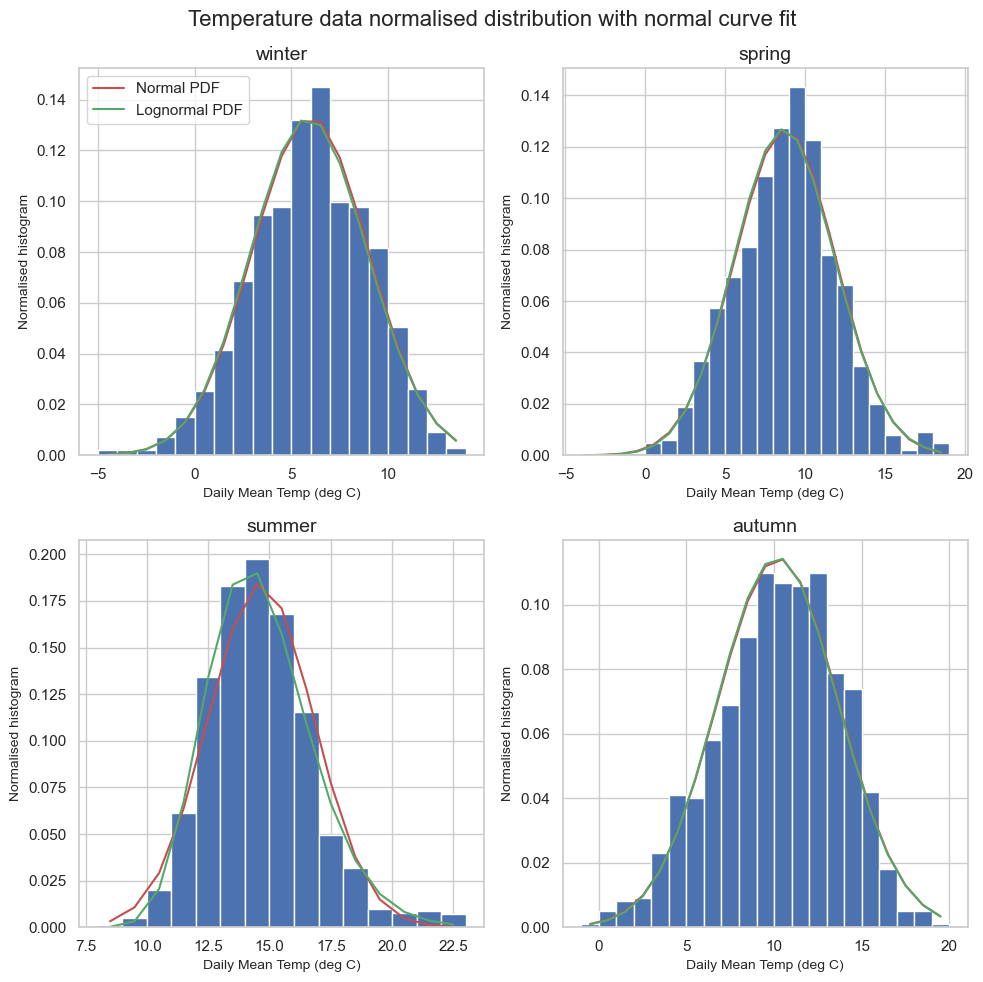

In [18]:
# Define empty lists to store the temperature params and frequency from the curve fit for data synthesisation later
temp_params_season_normal = []
temp_params_season_lognormal = []
temp_df = mydata_agg_i[['Temp mean', 'datetime', 'season']]
temp_df = temp_df.set_index('datetime')
# 
fig, axs = plt.subplots(2,2, figsize=(10, 10));
fig.suptitle('Temperature data normalised distribution with normal curve fit', fontsize=16)
# Axis list for looping over axes below
ax_list = [(0,0), (0,1), (1,0), (1,1)] 
  
for i, season in enumerate(class_names):
  temp_df_season = pd.DataFrame()
  temp_df_season = temp_df[temp_df['season'] == season].drop(columns=['season'])
  
  # defining the bin size
  bin_size = 1
  # find the min and max of the data
  data_floor = math.floor(temp_df_season['Temp mean'].min())
  data_ceiling = math.ceil(temp_df_season['Temp mean'].max())

  # Generate a list of bins based on the min and max above to fit the data
  bins = np.arange(data_floor, data_ceiling+bin_size, bin_size)
  # Returns the normalised data for the histogram (area under curve =1)
  n, bins_returned, _ = axs[ax_list[i]].hist(temp_df_season['Temp mean'], bins=bins, density=True)
  
  # Gets the mid-point of the bins
  bin_mid = mean_bins(bins_returned)
  mu_temp = temp_df_season['Temp mean'].mean()
  sigma = temp_df_season['Temp mean'].std()
  # Getting curve fits this time with scipy stats
  param_normal = norm.fit(temp_df_season['Temp mean'])
  print(param_normal)
  param_lognormal = lognorm.fit(temp_df_season['Temp mean'])
  print(param_lognormal)
  # plotting the fitted pdf curves for normal and log normal
  pdf_fitted_norm = norm.pdf(bin_mid, loc=param_normal[0], scale=param_normal[1])
  pdf_fitted_lognorm = lognorm.pdf(bin_mid, param_lognormal[0], param_lognormal[1], param_lognormal[2])
  # store tuples to this list for use in the data synth later
  temp_params_season_normal.append((param_normal[0], param_normal[1]))
  temp_params_season_lognormal.append((param_lognormal[0], param_lognormal[1], param_lognormal[2]))
  # fit a normal curve
  axs[ax_list[i]].plot(bin_mid, pdf_fitted_norm, 'r', label='Normal PDF')
  axs[ax_list[i]].plot(bin_mid, pdf_fitted_lognorm, 'g', label='Lognormal PDF')
  
  axs[ax_list[i]].set_xlabel(f'Daily Mean Temp (deg C)', fontsize=10)
  axs[ax_list[i]].set_ylabel(f'Normalised histogram', fontsize=10)
  axs[ax_list[i]].set_title(season, fontsize=14)
  axs[ax_list[i]].grid(visible=True, which='both', axis='both')
axs[(0,0)].legend();
fig.tight_layout()

## Wind Speed Data Analysis <a id="Wind"></a> <span style="font-size: 8pt;"> [[TOC]](#toc)</span> 

The preliminary analysis shows mean wind speed to have a tail for higher values. This distribution does not look normal or indeed log normal as the temperature and pressure above does.  A rayleigh distribution is often used to model wind speed, however, Weibull is also used [12] for modelling extreme values.

The data below seems well represented by a mixture of Log normal (summer and autumn) and Rayleigh (winter and spring). Generally, the log normal and Rayleigh distributions are a better fit to the data than the normal distribution which fails to capture the extreme values as accuractly as Rayleigh and Log normal.


(0.32798244257195147, -3.0289308644011257, 10.647930435071839)
(0.2867008684324649, -2.759546556965966, 9.966574995458467)
(0.31529722357165646, -1.013386494251232, 7.271638888172905)
(0.2560671584502283, -3.7663792030892584, 10.237966309274665)


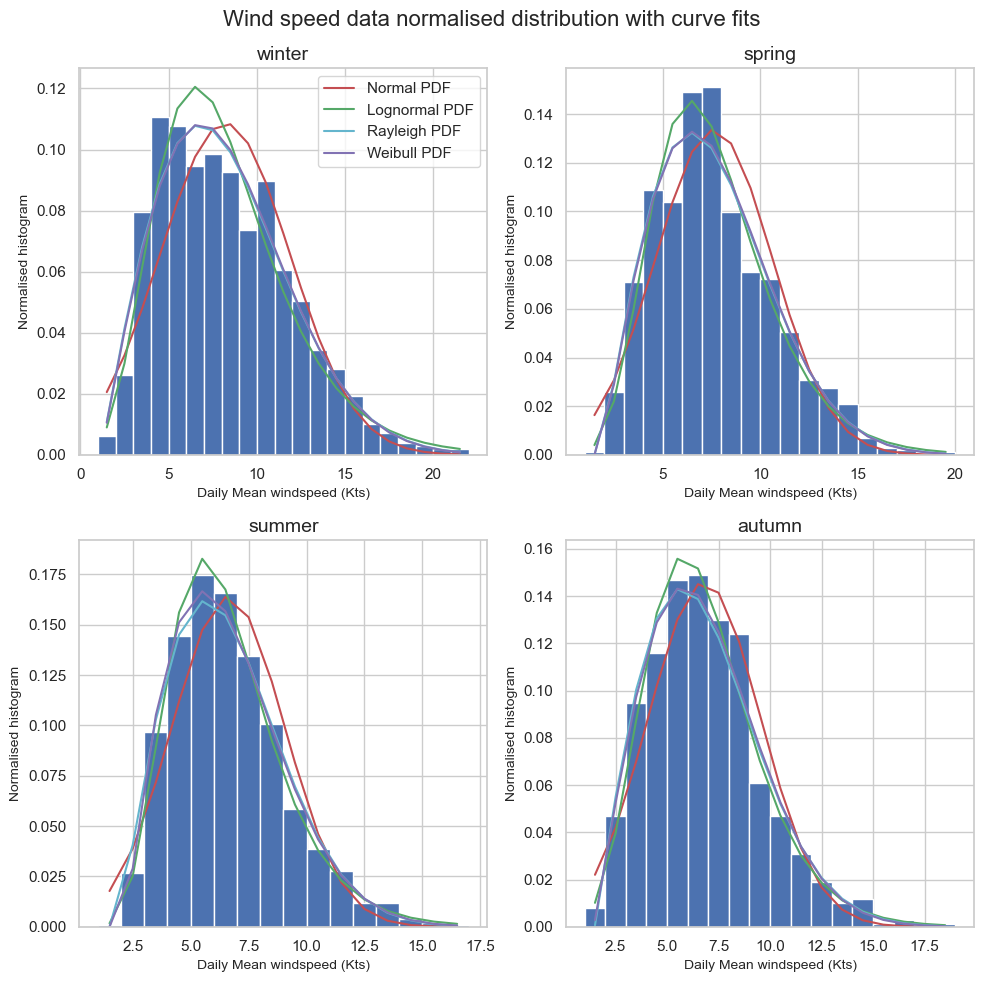

In [19]:
# Define empty lists to store the wind params and frequency from the curve fit for data synthesisation later
wind_params_season_normal = []
wind_params_season_lognormal = []
wind_params_season_rayleigh = []
# isolate the wind data
wind_df = mydata_agg_i[['Windspeed mean', 'datetime', 'season']]
wind_df = wind_df.set_index('datetime')
# 
fig, axs = plt.subplots(2,2, figsize=(10, 10));
fig.suptitle('Wind speed data normalised distribution with curve fits', fontsize=16)
# Axis list for looping over axes below
ax_list = [(0,0), (0,1), (1,0), (1,1)] 
  
for i, season in enumerate(class_names):
  wind_df_season = pd.DataFrame()
  wind_df_season = wind_df[wind_df['season'] == season].drop(columns=['season'])
  
  # defining the bin size
  bin_size = 1
  # find the min and max of the data
  data_floor = math.floor(wind_df_season['Windspeed mean'].min())
  data_ceiling = math.ceil(wind_df_season['Windspeed mean'].max())

  # Generate a list of bins based on the min and max above to fit the data
  bins = np.arange(data_floor, data_ceiling+bin_size, bin_size)
  # Returns the normalised data for the histogram (area under curve =1)
  n, bins_returned, _ = axs[ax_list[i]].hist(wind_df_season['Windspeed mean'], bins=bins, density=True)
  
  # Gets the mid-point of the bins
  bin_mid = mean_bins(bins_returned)
  mu_wind = wind_df_season['Windspeed mean'].mean()
  sigma = wind_df_season['Windspeed mean'].std()
  # Getting curve fits this time with scipy stats
  param_normal = norm.fit(wind_df_season['Windspeed mean'])
  param_lognormal = lognorm.fit(wind_df_season['Windspeed mean'])
  param_rayleigh = rayleigh.fit(wind_df_season['Windspeed mean'])
  print(param_lognormal)
  param_weibull = weibull_min.fit(wind_df_season['Windspeed mean'])
  # Generate some fitted curves using scipy stats 
  pdf_fitted_norm = norm.pdf(bin_mid, loc=param_normal[0], scale=param_normal[1])
  pdf_fitted_lognorm = lognorm.pdf(bin_mid, param_lognormal[0], param_lognormal[1], param_lognormal[2])
  pdf_fitted_rayleigh = rayleigh.pdf(bin_mid, param_rayleigh[0], param_rayleigh[1])
  pdf_fitted_weibull = weibull_min.pdf(bin_mid, param_weibull[0], param_weibull[1], param_weibull[2])
  # store tuples to this list for use in the data synth later
  wind_params_season_normal.append((param_normal[0], param_normal[1]))
  wind_params_season_lognormal.append((param_lognormal[0], param_lognormal[1], param_lognormal[2]))
  wind_params_season_rayleigh.append((param_rayleigh[0], param_rayleigh[1]))
  # plotting the fitted pdf curves for normal and log normal
  axs[ax_list[i]].plot(bin_mid, pdf_fitted_norm, 'r', label='Normal PDF')
  axs[ax_list[i]].plot(bin_mid, pdf_fitted_lognorm, 'g', label='Lognormal PDF')
  axs[ax_list[i]].plot(bin_mid, pdf_fitted_rayleigh, 'c', label='Rayleigh PDF')
  axs[ax_list[i]].plot(bin_mid, pdf_fitted_weibull, 'm', label='Weibull PDF')
  
  axs[ax_list[i]].set_xlabel(f'Daily Mean windspeed (Kts)', fontsize=10)
  axs[ax_list[i]].set_ylabel(f'Normalised histogram', fontsize=10)
  axs[ax_list[i]].set_title(season, fontsize=14)
  axs[ax_list[i]].grid(visible=True, which='both', axis='both')
axs[(0,0)].legend();
fig.tight_layout()

## Data Synthesisation <a id="Synth"></a> <span style="font-size: 8pt;"> [[TOC]](#toc)</span>

In the preceding sections, a collection of PDF fitted curves and associated parameters has been generated based on the dataset daily aggregation.  In this section, the synthesisation of the meteorological values will be attempted, using the fitted parameters for each of the 4 seasons and using Numpy random generators as appropriate.

Note that synthesised data will be indicated "_s" below.

### Rainfall Data Synthesisation
Daily rainfall data synthesisation will be carried out as follows:

The frequency of rainless days with a frequency of (1-fw) will be used to generate a corresponding number of days in the synthesised data with no rain. 
- The number of dry days is found by subtracting rainy days from the total number of days and a value of 0 is assigned.
- It is possible to generate data for 1 year to synthesise daily rainfall totals by the following:
    -- generate some random data based on the exponential distribution parameters which describe the rainfall daily total distribution. The size of the random data is based on the frequency of rainy days, fw, multiplied by the total number of days of required data [14]. 
- The 2 arrays are joined together and then shuffled randomly.

### Temperature Data
Pressure data was generated with the numpy.random.lognormal generator.

###



In [20]:
# First, set up some parameters for the synthesised dataset
# no_days is number of rows in synthesised dataset
no_years = 1
var_names_synth = ['Rainfall sum_s', 'Temp mean_s', 'Pressure mean_s', 'Windspeed mean_s', 'season'] # to allow looping over variables
# empty dataframe for storing the synthesised data
# add column for day number https://stackoverflow.com/questions/16327055/how-to-add-an-empty-column-to-a-dataframe
# no of days in each season
season_days = [31+31+28, 31+30+31, 30+31+31, 30+31+30]
met_data_synth = pd.DataFrame(index=range(365*no_years), columns=var_names_synth)

# set up a pdf fit dictionary for temperature and wind
temp_fit_dict = {'winter':'normal', 'spring':'normal', 'summer':'normal', 'autumn':'normal'}
wind_fit_dict = {'winter':'rayleigh', 'spring':'rayleigh', 'summer':'rayleigh', 'autumn':'rayleigh'}

# Assign the seasons to the empty dataframe - in the correct order, tho it shouldn't matter because each year is generated identically
for i in range(no_years):
  start_index = 0
  for j, season in enumerate(class_names):
    season_class = np.array(season_days[j] * [class_names[j]])
    end_index = start_index + len(season_class) -1 
    met_data_synth['season'].loc[start_index:end_index] = season_class
    start_index = end_index + 1


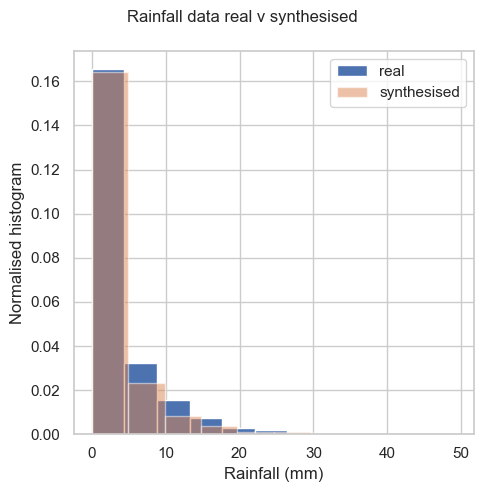

In [21]:
# Rainfall synthesisation
# set up a random generator for exponential distribution
# https://numpy.org/devdocs/reference/random/generated/numpy.random.Generator.exponential.html
# generate 1 year of daily rainfall totals - assuming that the frequency of rainy days calculated above
# initialise a numpy array from an empty list
rainfall_syn_data = np.array([])
start_index = 0
for y in range(no_years):
  for i, season in enumerate(class_names):
    # Generate the random rainfall data using the numpy exponential 
    random_rainfall_season = np.random.default_rng().exponential(1/rainfall_exp_params_season[i], int(season_days[i]*fw_seasonal[i]))
    # Get the number of rainy days and non-rainy days
    rainfall_days_season = int(fw_seasonal[i] * season_days[i])
    non_rainfall_days_season = np.array((season_days[i]-rainfall_days_season)*[0])
    rainfall_syn_data_season = np.concatenate((random_rainfall_season, non_rainfall_days_season))
    # Mix up the 0 rainfall and rainfall days randomly  
    np.random.shuffle(rainfall_syn_data_season)
    rainfall_syn_data = np.concatenate((rainfall_syn_data, rainfall_syn_data_season))
  end_index = start_index + 365 - 1 
  met_data_synth['Rainfall sum_s'].loc[start_index:end_index] = rainfall_syn_data
  start_index = end_index + 1  
  

# compare the real data with the synthesised data
fig, ax = plt.subplots(1, figsize=(5, 5));
fig.suptitle('Rainfall data real v synthesised', fontsize=12)
ax.hist(mydata_agg_i['Rainfall sum'], bins=10, density=True, label='real')
ax.hist(met_data_synth['Rainfall sum_s'], bins=10, density=True, alpha=0.5, label='synthesised')
ax.set_xlabel(f'Rainfall (mm)', fontsize=12)
ax.set_ylabel(f'Normalised histogram', fontsize=12)
ax.legend()
fig.tight_layout()
plt.show()


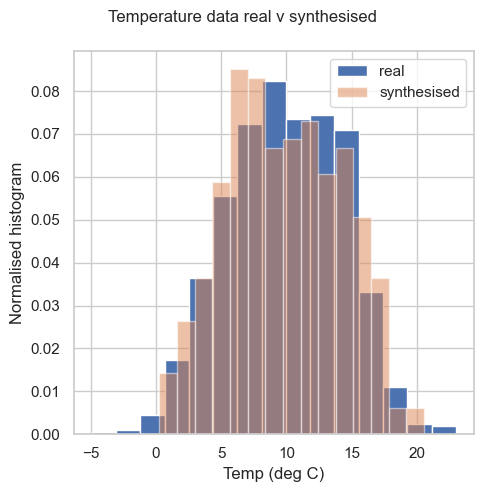

In [22]:
# Temperature synthesisation

# initialise a numpy array from an empty list
temp_syn_data = np.array([])

start_index = 0
for y in range(no_years):
  for i, season in enumerate(class_names):
    # Generate the random temp data using the numpy normal or log normal generator as per dictionary defined above
    if temp_fit_dict[season] == "normal":
      random_temp_season = np.random.default_rng().normal(temp_params_season_normal[i][0], temp_params_season_normal[i][1], season_days[i])
    elif temp_fit_dict[season] == "lognormal":
      # slightly different as lognormal params were generated from scipy stats
      random_temp_season = np.random.lognormal(temp_params_season_lognormal[i][0], temp_params_season_lognormal[i][1], season_days[i])

    temp_syn_data = np.concatenate((temp_syn_data, random_temp_season))
  end_index = start_index + 365 - 1 
  met_data_synth['Temp mean_s'].loc[start_index:end_index] = temp_syn_data
  start_index = end_index + 1  

# compare the real data with the synthesised data
fig, ax = plt.subplots(1, figsize=(5, 5));
fig.suptitle('Temperature data real v synthesised', fontsize=12)
ax.hist(mydata_agg_i['Temp mean'], bins=15, density=True, label='real')
ax.hist(met_data_synth['Temp mean_s'], bins=15, density=True, alpha=0.5, label='synthesised')
ax.set_xlabel(f'Temp (deg C)', fontsize=12)
ax.set_ylabel(f'Normalised histogram', fontsize=12)
ax.legend()
fig.tight_layout()
plt.show()


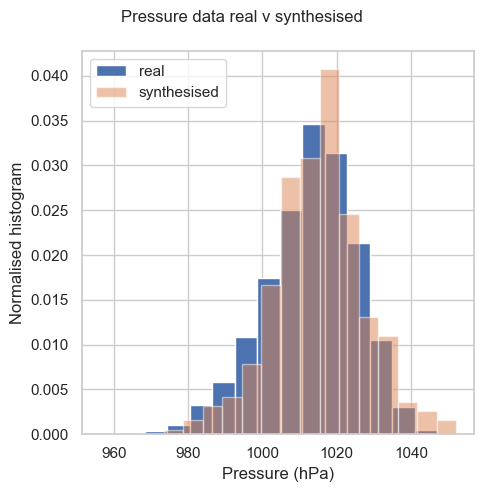

In [23]:
# Pressure data synthesisation

# initialise a numpy array from an empty list
pressure_syn_data = np.array([])
start_index = 0
for y in range(no_years):
  for i, season in enumerate(class_names):
    # Generate the random pressure data using the log normal generator 
    random_pressure_season = np.random.default_rng().lognormal(pressure_params_season[i][0], pressure_params_season[i][1], season_days[i])
    # add the season's data onto the end of the array
    pressure_syn_data = np.concatenate((pressure_syn_data, random_pressure_season))
  end_index = start_index + 365 - 1 
  met_data_synth['Pressure mean_s'].loc[start_index:end_index] = pressure_syn_data
  start_index = end_index + 1  
  
# compare the real data with the synthesised data
fig, ax = plt.subplots(1, figsize=(5, 5));
fig.suptitle('Pressure data real v synthesised', fontsize=12)
ax.hist(mydata_agg_i['Pressure mean'], bins=15, density=True, label='real')
ax.hist(met_data_synth['Pressure mean_s'], bins=15, density=True, alpha=0.5, label='synthesised')
ax.set_xlabel(f'Pressure (hPa)', fontsize=12)
ax.set_ylabel(f'Normalised histogram', fontsize=12)
ax.legend()
fig.tight_layout()
plt.show()


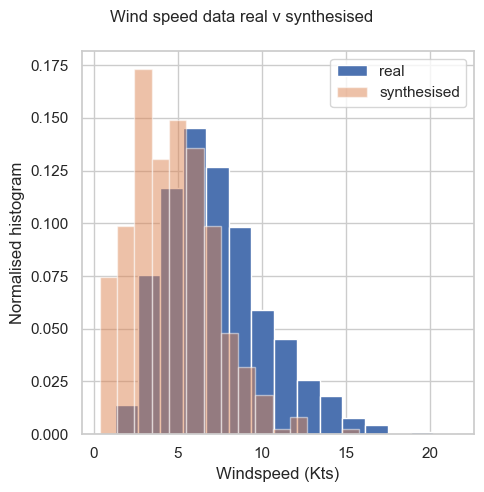

In [24]:
# Wind speed synthesisation - changing to rayleigh for all as issues with lognormal
wind_fit_dict = {'winter':'rayleigh', 'spring':'rayleigh', 'summer':'rayleigh', 'autumn':'rayleigh'}
# initialise a numpy array from an empty list
wind_syn_data = np.array([])
start_index = 0
for y in range(no_years):
  for i, season in enumerate(class_names):
    random_wind_season = np.array([])
    # Generate the random temp data using the numpy normal or log normal generator as per dictionary defined above
    if wind_fit_dict[season] == "lognormal":
      mean = np.log(wind_params_season_lognormal[i][2])
      #print(mean)
      std_dev = wind_params_season_lognormal[i][0]
      #print(std_dev)
      random_wind_season = np.random.default_rng().lognormal(wind_params_season_lognormal[i][0], wind_params_season_lognormal[i][1], season_days[i])
      #random_wind_season = np.random.default_rng().lognormal(mean, std_dev, season_days[i])
      #print(random_wind_season)
    elif wind_fit_dict[season] == "rayleigh":
      mode = np.sqrt(2 / np.pi) * wind_params_season_rayleigh[i][1]
      random_wind_season = np.random.rayleigh(mode, season_days[i])
      #print(wind_params_season_rayleigh[i][0])
    wind_syn_data = np.concatenate((wind_syn_data, random_wind_season))
    end_index = start_index + 365 - 1 
  met_data_synth['Windspeed mean_s'].loc[start_index:end_index] = wind_syn_data
  start_index = end_index + 1  

# compare the real data with the synthesised data
fig, ax = plt.subplots(1, figsize=(5, 5));
fig.suptitle('Wind speed data real v synthesised', fontsize=12)
ax.hist(mydata_agg_i['Windspeed mean'], bins=15, density=True, label='real')
ax.hist(met_data_synth['Windspeed mean_s'], bins=15, density=True, alpha=0.5, label='synthesised')
ax.set_xlabel(f'Windspeed (Kts)', fontsize=12)
ax.set_ylabel(f'Normalised histogram', fontsize=12)
ax.legend()
fig.tight_layout()
plt.show()
# Finally write out the synthesised dataset to a csv file
met_data_synth.to_csv("data/synthesised_met_data.csv")


In [32]:
# Display the correlation table for the entire dataset
corr_styler_list = []
# For some reason, having to force everything to floats
met_data_synth[['Rainfall sum_s', 'Temp mean_s', 'Pressure mean_s', 'Windspeed mean_s']] = met_data_synth[['Rainfall sum_s', 'Temp mean_s', 'Pressure mean_s', 'Windspeed mean_s']].astype(float)
df_corr =  get_corr(met_data_synth.drop(columns = ["season"]))    
df_styler = my_styler(df_corr, 2,  "Correlation - all data")
df_styler = styler_highlight_between(df_styler, 0.3, 0.99)
df_styler = styler_highlight_between(df_styler, -0.99, -0.3)
corr_styler_list = [df_styler]

# Get correlation matrices for the 4 seasons and display
for i, item in enumerate(class_names):
    # Extract the data related to one season
    season_data = met_data_synth[met_data_synth["season"] == item].copy()
    # Strip the class column before passing to function
    season_data.drop(columns = ["season"], inplace=True) 
    # For some reason, having to force everything to floats
    season_data[['Rainfall sum_s', 'Temp mean_s', 'Pressure mean_s', 'Windspeed mean_s']] = season_data[['Rainfall sum_s', 'Temp mean_s', 'Pressure mean_s', 'Windspeed mean_s']].astype(float)
    df_corr = get_corr(season_data)      
    df_styler = my_styler(df_corr, 2, item + " Correlation")
    df_styler = styler_highlight_between(df_styler, 0.3, 0.99)
    df_styler = styler_highlight_between(df_styler, -0.99, -0.3)
    corr_styler_list.append(df_styler)
    
for item in corr_styler_list:
    display(item)

0.3 0.99
-0.99 -0.3
0.3 0.99
-0.99 -0.3
0.3 0.99
-0.99 -0.3
0.3 0.99
-0.99 -0.3
0.3 0.99
-0.99 -0.3


,Rainfall sum_s,Temp mean_s,Pressure mean_s,Windspeed mean_s
Rainfall sum_s,1.00,-0.04,-0.03,0.03
Temp mean_s,-0.04,1.00,0.04,-0.12
Pressure mean_s,-0.03,0.04,1.00,0.03
Windspeed mean_s,0.03,-0.12,0.03,1.00


,Rainfall sum_s,Temp mean_s,Pressure mean_s,Windspeed mean_s
Rainfall sum_s,1.00,0.00,0.03,0.10
Temp mean_s,0.00,1.00,0.06,0.15
Pressure mean_s,0.03,0.06,1.00,-0.03
Windspeed mean_s,0.10,0.15,-0.03,1.00


,Rainfall sum_s,Temp mean_s,Pressure mean_s,Windspeed mean_s
Rainfall sum_s,1.00,-0.05,0.04,0.07
Temp mean_s,-0.05,1.00,-0.13,-0.01
Pressure mean_s,0.04,-0.13,1.00,0.12
Windspeed mean_s,0.07,-0.01,0.12,1.00


,Rainfall sum_s,Temp mean_s,Pressure mean_s,Windspeed mean_s
Rainfall sum_s,1.00,0.14,0.03,0.07
Temp mean_s,0.14,1.00,0.06,0.08
Pressure mean_s,0.03,0.06,1.00,0.07
Windspeed mean_s,0.07,0.08,0.07,1.00


,Rainfall sum_s,Temp mean_s,Pressure mean_s,Windspeed mean_s
Rainfall sum_s,1.00,0.08,-0.08,-0.16
Temp mean_s,0.08,1.00,-0.09,0.20
Pressure mean_s,-0.08,-0.09,1.00,0.18
Windspeed mean_s,-0.16,0.20,0.18,1.00


## Conclusions <a id="Conclusions"></a> <span style="font-size: 8pt;"> [[TOC]](#toc)</span>

- The dataset which comprised hourly meteorological data (2012 - 2022) was aggregated and analysed on the basis of splitting the data into the 4 meteorological seasons.
- There was no strong correlation (>0.7 deemed to be reasonably strong correlation) found between any of the variables in the real dataset (weak correlations were found between pressure and rainfall and pressure and wind speed). The highest correlation value was -0.47 between pressure and rainfall.
- For each of the 4 chosen meteorological variables, a suitable distribution was chosen and fitted to the data for each of the 4 seasons. Parameters for PDF generation were stored for each season and each variable
- Random data was generated for each of the 4 seasons for each data variable for each season.
- To test the random number generation, 1 years worth of data was synthesised with Numpy random distribution generators. The generated histograms were compared to the real dataset.
- Good agreement between real and synthesised data was found for pressure and temperature datasets. Both of these are largely normally distributed. The synthesised wind speed data (rayleigh) was skewed towards lower values.
- The correlation values are lower than those of the original dataset as no correlation (such as with linear regression or multivariate analysis) was forced on the data.

## References <a id="Refs"></a> <span style="font-size: 8pt;"> [[TOC]](#toc)</span>
1. Met.ie dataset source: https://www.met.ie/climate/available-data/historical-data
2. Replacing blanks with nans: https://stackoverflow.com/questions/13445241/replacing-blank-values-white-space-with-nan-in-pandas
3. Setting/resetting index: https://sparkbyexamples.com/pandas/pandas-set-index-to-column-in-dataframe/
4. Rainfall distribution: https://www.realclimate.org/index.php/archives/2017/11/a-brief-review-of-rainfall-statistics/. 
5. fitting distributions/picking distribution: https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python/16651955#16651955
6. Exponential curve fitting:  https://www.geeksforgeeks.org/how-to-do-exponential-and-logarithmic-curve-fitting-in-python/
7. Curve fitting: https://stackoverflow.com/questions/50448199/lognormal-curve-fit
8. Curve fitting: https://www.geeksforgeeks.org/how-to-do-exponential-and-logarithmic-curve-fitting-in-python/
9. Scipy curve fitting: https://stackoverflow.com/questions/2896179/fitting-a-gamma-distribution-with-python-scipy 
10. Scipy manual: https://docs.scipy.org/doc/scipy/reference/stats.html
11. Scipy curve fitting: https://glowingpython.blogspot.com/2012/07/distribution-fitting-with-scipy.html
12. Wind speed PDF: https://www.sciencedirect.com/topics/engineering/wind-speed-distribution
13. Wind speed PDF: https://www.frontiersin.org/articles/10.3389/fenrg.2021.769920/full
14. Numpy generator exponential: https://numpy.org/devdocs/reference/random/generated/numpy.random.Generator.exponential.html
15. Scipy stats details of PDF curve fitting: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.fit.html#scipy.stats.rv_continuous.fit
16. Scipy stats parameters v underlying mu and sigma for lognormal data generation: https://stackoverflow.com/questions/51609299/python-np-lognormal-gives-infinite-results-for-big-average-and-st-dev
17. Multivariate data fit: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html#scipy.stats.multivariate_normal
18. Multivariate ranom data generation: https://numpy.org/doc/stable/reference/random/generated/numpy.random.multivariate_normal.html
19. Linear regression in scipy: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html
